#  XPCS   Pipeline 

Get the data from databroker

In [337]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE
# register the fancy lazy chx eiger handler
# from chxtools import handlers

### Lazy Eiger Handler (later will goto databroker)

In [338]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

### Get the events from the uid

In [339]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))

#f = h5py.File('/XF11ID/data/2015/10/16/bcdd8b95-6adc-476b-9c65_25_master.h5','r')
#f.visititems(print_attrs)

In [340]:
hdr = db[-1]

In [341]:
#hdr = db[{{ uid }}]

In [342]:
list(hdr.keys())

['descriptors', 'stop', 'start']

In [343]:
#ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'])

In [344]:
#imgs = ev['data']['eiger_4M_cam_img_image_lightfield']

In [345]:
from eiger_io.pims_reader import EigerImages

In [346]:
%matplotlib inline


In [347]:
datafile = '/XF11ID/data/2015/10/28/Si_500nm_PG100K5p_9032_master.h5'
f = h5py.File(datafile,'r')
#f.visititems(print_attrs)
imgs= EigerImages(datafile)
imgs.md = {k: f[v].value for k, v in EIGER_MD_DICT.items()}
pixel_mask = imgs.md['pixel_mask']
pixel_mask[pixel_mask>0] = 1
pixel_mask[pixel_mask==0] = 2
pixel_mask[pixel_mask==1] = 0
pixel_mask[pixel_mask==2] = 1
        
        

In [348]:
imgs,imgs.md

(<Frames>
 Length: 2500 frames
 Frame Shape: 2167 x 2070
 Pixel Datatype: uint16,
 {'beam_center_x': 840.0,
  'beam_center_y': 336.0,
  'count_time': 0.0049899998,
  'detector_distance': 4.8400002,
  'frame_time': 0.0049999999,
  'incident_wavelength': 1.3794414,
  'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ..., 
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
  'x_pixel_size': 7.5000004e-05,
  'y_pixel_size': 7.5000004e-05})

In [349]:
#imgs.md['pixel_mask'] =np.array( imgs.md['pixel_mask'],dtype=np.uint16   )

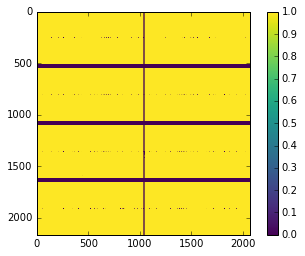

In [350]:
%matplotlib inline

plt.figure()
plt.imshow(imgs.md['pixel_mask'], vmin=0,vmax=1,cmap='viridis')
plt.colorbar()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

In [351]:
from time import sleep

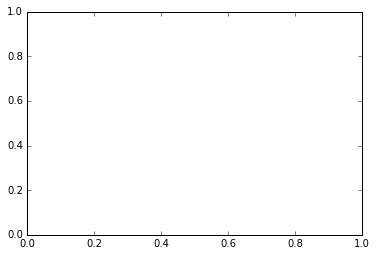

In [352]:
%matplotlib inline
from ipywidgets import interact
N = len(imgs)

N= 0

def view_image(sleeps=1):
    fig,ax=plt.subplots()
    for i in range(N):
        ax.imshow(imgs[i], interpolation='nearest', cmap='viridis', vmin=0, vmax=1e0)
        sleep(sleeps)
        plt.title("Browse the Image Stack")
        plt.show()

        
view_image(1)        
#interact(view_image)


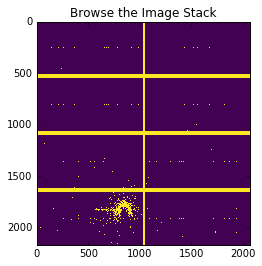

In [397]:
%matplotlib inline
from ipywidgets import interact

def view_image(i):
    plt.imshow(imgs[i], interpolation='nearest', cmap='viridis', vmin=0, vmax=1e0)
    plt.title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, len(imgs)-1))

In [354]:
#hey, let's see if any images are bad!
imgsum = [np.sum(img*imgs.md['pixel_mask']) for img in imgs[::25]]

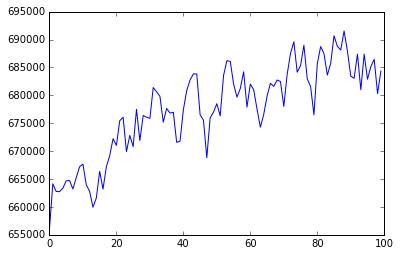

In [355]:
%matplotlib inline
plt.plot(imgsum)

### Get the Averaged Image Data

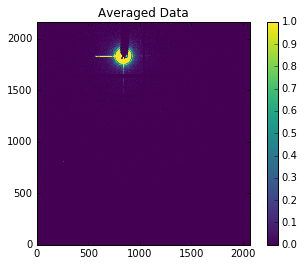

In [356]:
avg_img = np.average(imgs[::50], axis=0) * imgs.md['pixel_mask']
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(avg_img, vmin=0, vmax=1e0, cmap='viridis',origin='lower')
fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [357]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi

import skxray.core.correlation as corr
import skxray.core.utils as utils

## Note:  Enter the following experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [358]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 336.0,
 'count_time': 0.0049899998,
 'detector_distance': 4.8400002,
 'frame_time': 0.0049999999,
 'incident_wavelength': 1.3794414,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [359]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

## Create the mask file

More information : https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

In [360]:
%matplotlib notebook

<IPython.core.display.Javascript object>


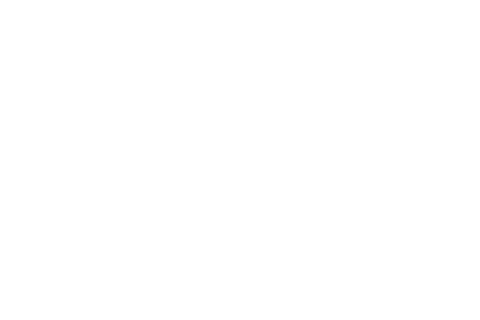

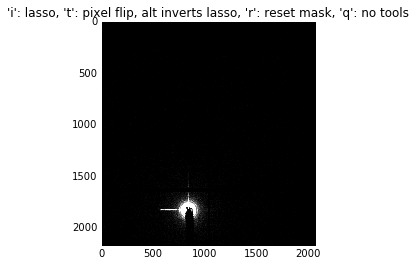

In [361]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img, vmin=0, vmax=1e0)

In [362]:
#np.save('mask_test', new_mask)


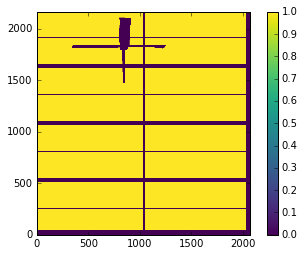

In [363]:

%matplotlib inline

#new_mask = m.mask
m.mask = new_mask
plt.imshow(~new_mask,origin='lower' ,vmin=0,vmax=1,cmap='viridis')
plt.colorbar()
plt.show()

### Combine the hand-drawn mask and the pixel mask

In [364]:
mask = ~m.mask * imgs.md['pixel_mask']

In [365]:
%matplotlib inline

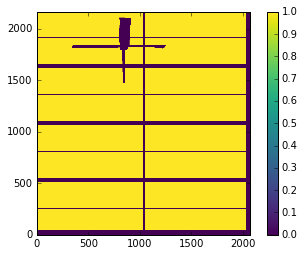

In [366]:
plt.figure()
plt.imshow(mask,origin='lower' ,vmin=0,vmax=1,cmap='viridis')
plt.colorbar()
plt.show()


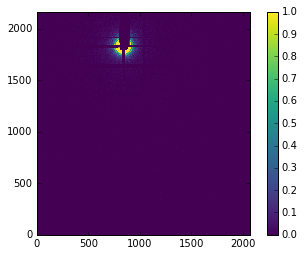

In [367]:
img_mask = avg_img * mask

#%matplotlib notebook
plt.figure()
plt.imshow(img_mask,origin='lower' ,vmin=0,vmax=1.0,cmap='viridis')
plt.colorbar()
plt.show()

## Get the approximate center and see the statistic to make sure 

In [368]:
#center = (1634.66, 838.6)  # center of the speckle pattern
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [840, 1830]

center

[840, 1830]

In [369]:
center2 = [1830, 840]

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [370]:
bin_centers, ring_averages= roi.circular_average(avg_img*mask, 
        center2, threshold=0, nx=1000, pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

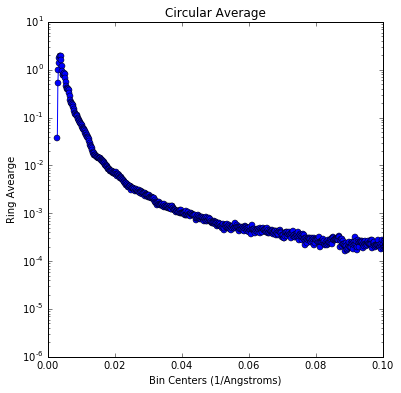

In [371]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title("Circular Average")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.1)
plt.show()

## Create label array (Q rings)

In [372]:
inner_radius = 45# radius of the first ring
width = 2       # width of each ring
spacing = 6+ 1/9.    # no spacing between rings
num_rings = 10   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  45.        ,   47.        ],
       [  53.11111111,   55.11111111],
       [  61.22222222,   63.22222222],
       [  69.33333333,   71.33333333],
       [  77.44444444,   79.44444444],
       [  85.55555556,   87.55555556],
       [  93.66666667,   95.66666667],
       [ 101.77777778,  103.77777778],
       [ 109.88888889,  111.88888889],
       [ 118.        ,  120.        ]])

In [373]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_val

array([[ 0.00307454,  0.00321119],
       [ 0.00362872,  0.00376536],
       [ 0.00418289,  0.00431954],
       [ 0.00473707,  0.00487372],
       [ 0.00529125,  0.00542789],
       [ 0.00584542,  0.00598207],
       [ 0.0063996 ,  0.00653624],
       [ 0.00695377,  0.00709042],
       [ 0.00750795,  0.00764459],
       [ 0.00806212,  0.00819877]])

In [374]:
q_ring_center = np.array( [(q_ring_val[i][0] + q_ring_val[i][1])/2 for 
                           i in range(num_rings)])
q_ring_center

array([ 0.00314286,  0.00369704,  0.00425122,  0.00480539,  0.00535957,
        0.00591374,  0.00646792,  0.0070221 ,  0.00757627,  0.00813045])

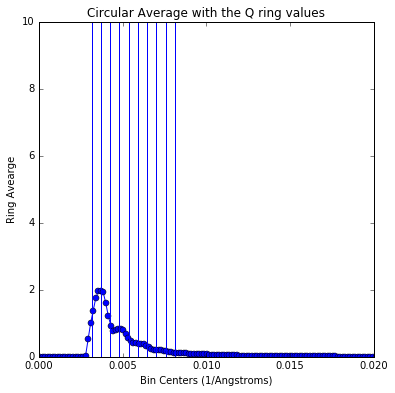

In [375]:
fig, axes = plt.subplots( figsize=(6, 6))
#axes.semilogy(q_val, ring_averages, '-o')

axes.plot(q_val, ring_averages, '-o')
axes.set_title("Circular Average with the Q ring values")
axes.set_ylabel("Ring Avearge")
axes.set_xlabel("Bin Centers (1/Angstroms)")
axes.set_xlim(0, 0.02)
axes.set_ylim(0, 10)
for i in range(num_rings):
    #axes.axvline(q_ring_val[i, 0])
    axes.axvline(q_ring_center[i])
plt.show()

In [376]:
center

[840, 1830]

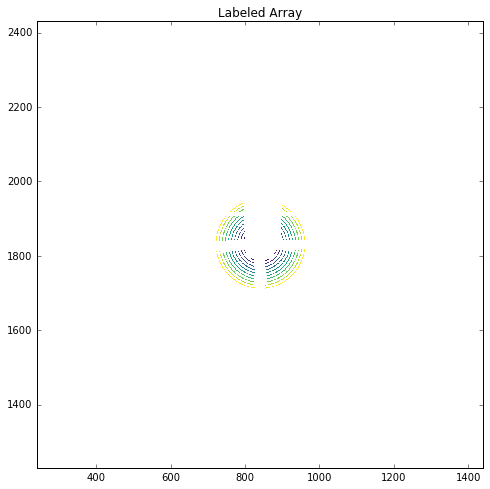

In [377]:
%matplotlib inline
rings = roi.rings(edges, center2, avg_img.shape)

ring_mask = rings*mask
#% matplotlib notebook
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis',origin='lower')

rwidth = 600 

y1,y2 = [center[1] - rwidth, center[1] + rwidth]
x1,x2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])
plt.show()

## Plot Kymograph (Waterfall plot) for a vertical and hortizontal cuts


Note : Give coordinates of the upper-left corner and width and height of each
rectangle: e.g., [(x, y, w, h), (x, y, w, h)]


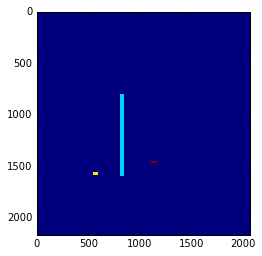

In [378]:
vert_rect = ((800, 803,800, 40), (1554, 546, 30, 40), (1454, 1098, 20, 60)) 

V_K_label_array = roi.rectangles(vert_rect, avg_img.shape)
plt.figure()
plt.imshow(V_K_label_array)
plt.show()

In [379]:
center

[840, 1830]

In [380]:
V_K_label_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##  Kymograph(waterfall plot) of the 3rd ring

In [381]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

In [382]:
masker = Masker(imgs, mask)

In [383]:
veri_kymo = roi.kymograph(masker, V_K_label_array*mask, num = 1)

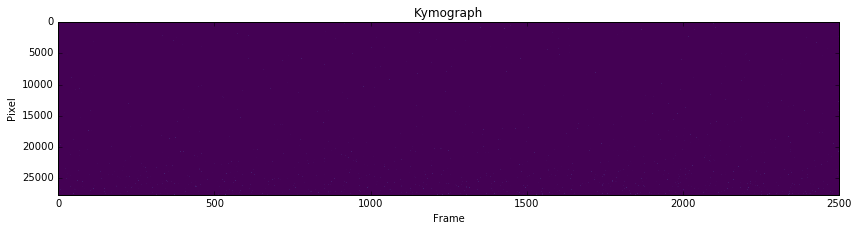

In [384]:

fig, ax = plt.subplots(figsize=(14,10))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(veri_kymo.T, cmap='viridis', vmax=10)
#fig.colorbar( im   )
ax.set_aspect(0.02)
plt.show()

##  Mean intensities for each ring

In [385]:
mask_data = masker[::50]
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

In [386]:
mean_int_sets.shape

(50, 10)

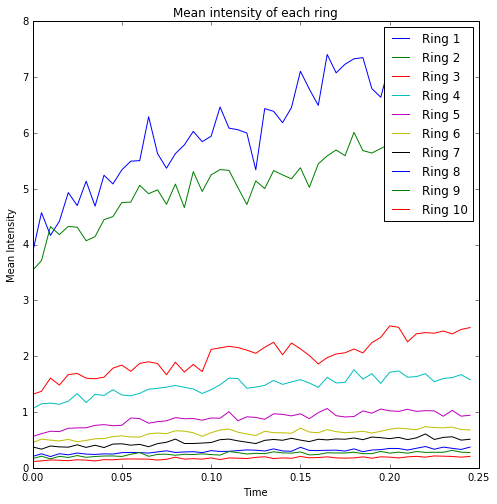

In [387]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## Extract the labeled array

In [388]:
labels, indices = roi.extract_label_indices(ring_mask)

In [389]:
nopr  = np.array( [ len(np.where(labels==i)[0]) for i in range( 1, num_rings+1) ] )
nopr

array([ 103,  273,  388,  507,  618,  704,  760,  876,  970, 1096])

In [390]:
subset = imgs[:100]

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [391]:
num_lev = 9  
num_buf = 8

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf, ring_mask,
                                           imgs)

In [392]:
%matplotlib inline

### Plot the one time correlation functions

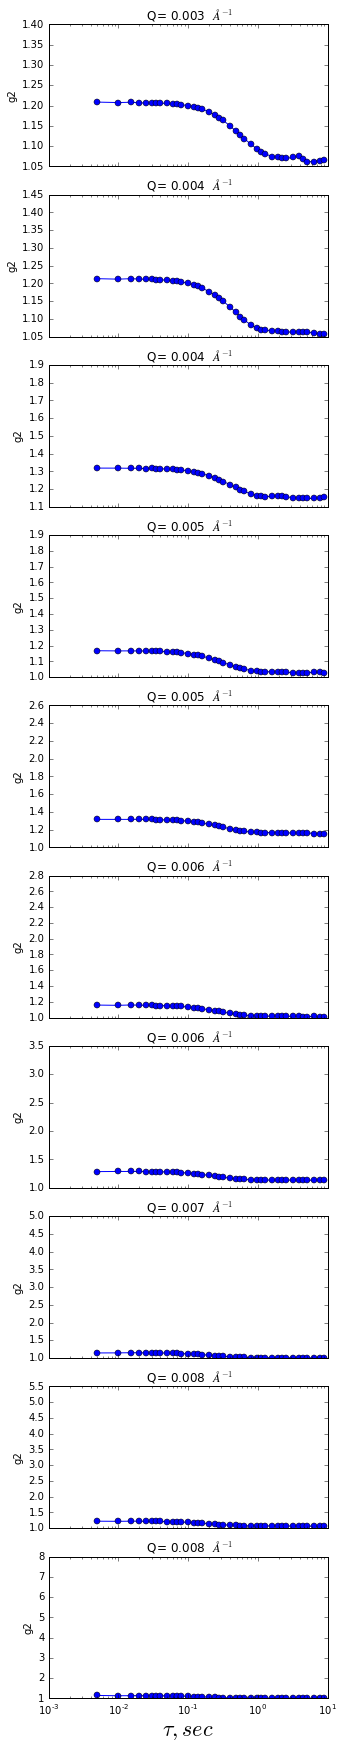

In [393]:
lags = lag_steps*timeperframe

fig, axes = plt.subplots(num_rings, sharex=True, figsize=(5, 30))
axes[num_rings-1].set_xlabel(r"$\tau,sec$", fontsize=22)
for i in range(num_rings):
    axes[i].set_ylabel("g2") 
    axes[i].set_title(" Q= " + '%.3f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    axes[i].semilogx(lags, g2[:, i], '-o', markersize=6)
    #axes[i].set_ylim(bottom=1.10, top=1.15)
plt.show()

# Fit g2

In [394]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)


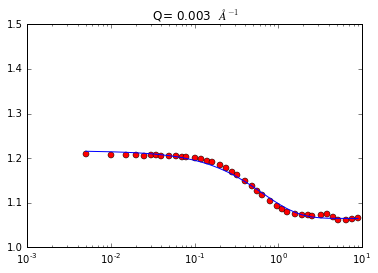

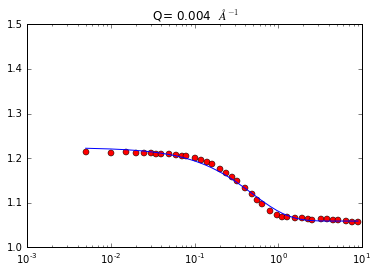

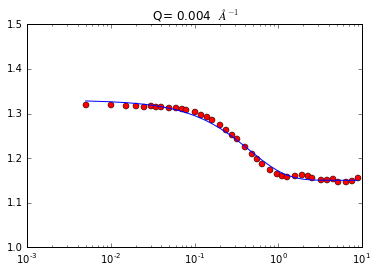

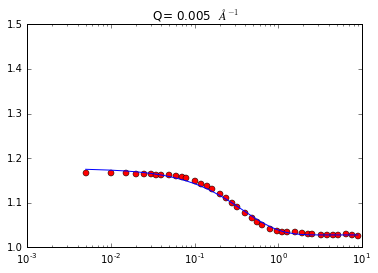

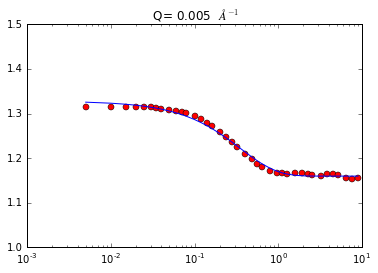

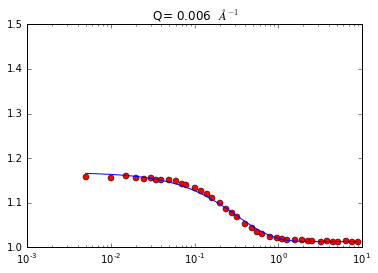

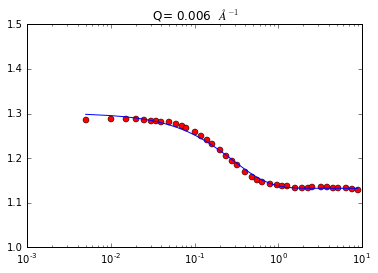

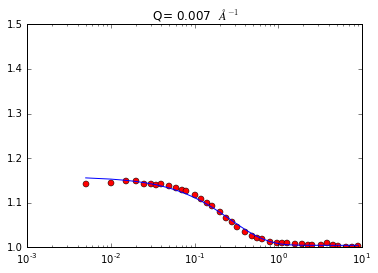

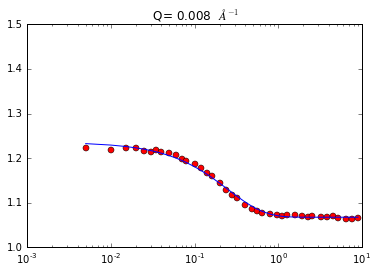

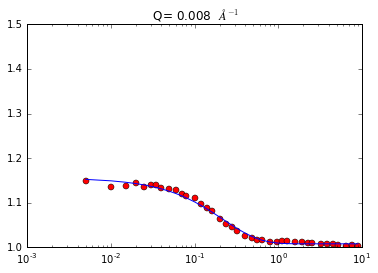

In [395]:
for i in range(num_rings):

    result1 = mod.fit(g2[1:,i], lags=lags[1:], beta=.1, relaxation_rate =.5,  baseline=1.0)

    plt.figure()
    plt.semilogx(lags[1:], g2[1:, i], 'ro')
    plt.semilogx(lags[1:], result1.best_fit, '-b')
    plt.ylim(1.0, 1.5)
    #axes[i].set_title(" Q= " + '%.3f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    
    plt.title(" Q= " + '%.3f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
plt.show()